This code has been taken from the gitub repo by Chinmayrane16


* Exploring the dataset-
The dataset we are going to use is the MovieLens Dataset, which cotains 100k ratings of approximately 9000 movies by 700 users. Let's have a look at the dataset.


In [67]:
# importing the libraries--
# for ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table like data and matrices
import numpy as np 
import pandas as pd
import math
import itertools


# Modelling helpers
from sklearn.preprocessing import Normalizer,scale
from sklearn.impute import SimpleImputer
from sklearn.model_selection import  train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Evaluation metrics:
# Regression 
from sklearn.metrics import mean_squared_log_error,mean_squared_error,r2_score,mean_absolute_error

#Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

# Deep learning libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

#Configure visualization
#%matplotlib inline, actually used to show the 
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [68]:
# Center all plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");


# Make Visualizations better
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

In [69]:
import os
print(os.listdir(r'C:\Users\divye\OneDrive\Desktop\Project\ML\Recomender_Systems\ml-100k'))

['allbut.pl', 'mku.sh', 'README', 'u.data', 'u.genre', 'u.info', 'u.item', 'u.occupation', 'u.user', 'u1.base', 'u1.test', 'u2.base', 'u2.test', 'u3.base', 'u3.test', 'u4.base', 'u4.test', 'u5.base', 'u5.test', 'ua.base', 'ua.test', 'ub.base', 'ub.test']


In [70]:
ratings=pd.read_csv(r'C:\Users\divye\OneDrive\Desktop\Project\ML\Recomender_Systems\ml-100k\u.data',header=None,names=['userid','productid','rating','timestamp'],sep='\t')
df_r=ratings.copy()
ratings.head()


,userid,productid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [71]:
ratings.shape

(100000, 4)

In [72]:
ratings.describe()

,userid,productid,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


The minimum rating given to the movie is 1 whereas the maximum rating given to the movies is 5.0
The average rating that is the mean ratings given by the users to all the movies is 3.529
The users have userId's in the range 1 - 943
The movies have movieId's in the range 1 - 1682.( Note that 193609 is the highest movieId and not total number of movies. )

In [73]:
ratings.drop('timestamp',axis=1,inplace=True)
ratings.head()

,userid,productid,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [74]:
import chardet as ch
with open(r'C:\Users\divye\OneDrive\Desktop\Project\ML\Recomender_Systems\ml-100k\u.item', 'rb') as f:
    result = ch.detect(f.read())
    encoding = result['encoding']
    print(encoding)
movies=pd.read_csv(r'C:\Users\divye\OneDrive\Desktop\Project\ML\Recomender_Systems\ml-100k\u.item',encoding='ISO-8859-1',sep="|",header=None,names=['productid','movie-title','release-date','video-release-date','IMDb-URL','unknown','Action','Adventure','Animation','Children','Comedy','Crime','Documentry','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-fi','Thriller','War','Western'])
movies.head()

ISO-8859-1


,productid,movie-title,release-date,video-release-date,IMDb-URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [75]:
df_combined=pd.merge(ratings, movies ,on='productid' )
df_combined.head(5)
# df_combined.info()


,userid,productid,rating,movie-title,release-date,video-release-date,IMDb-URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-fi,Thriller,War,Western
0,196,242,3,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


{'Action': 25589, 'Adventure': 13753, 'Animation': 3605, 'Children': 7182, 'Comedy': 29832, 'Crime': 8055, 'Documentry': 758, 'Drama': 39895, 'Fantasy': 1352, 'Film-Noir': 1733, 'Horror': 5317, 'Musical': 4954, 'Mystery': 5245, 'Romance': 19461, 'Sci-fi': 12730, 'Thriller': 21872, 'War': 9398, 'Western': 1854}


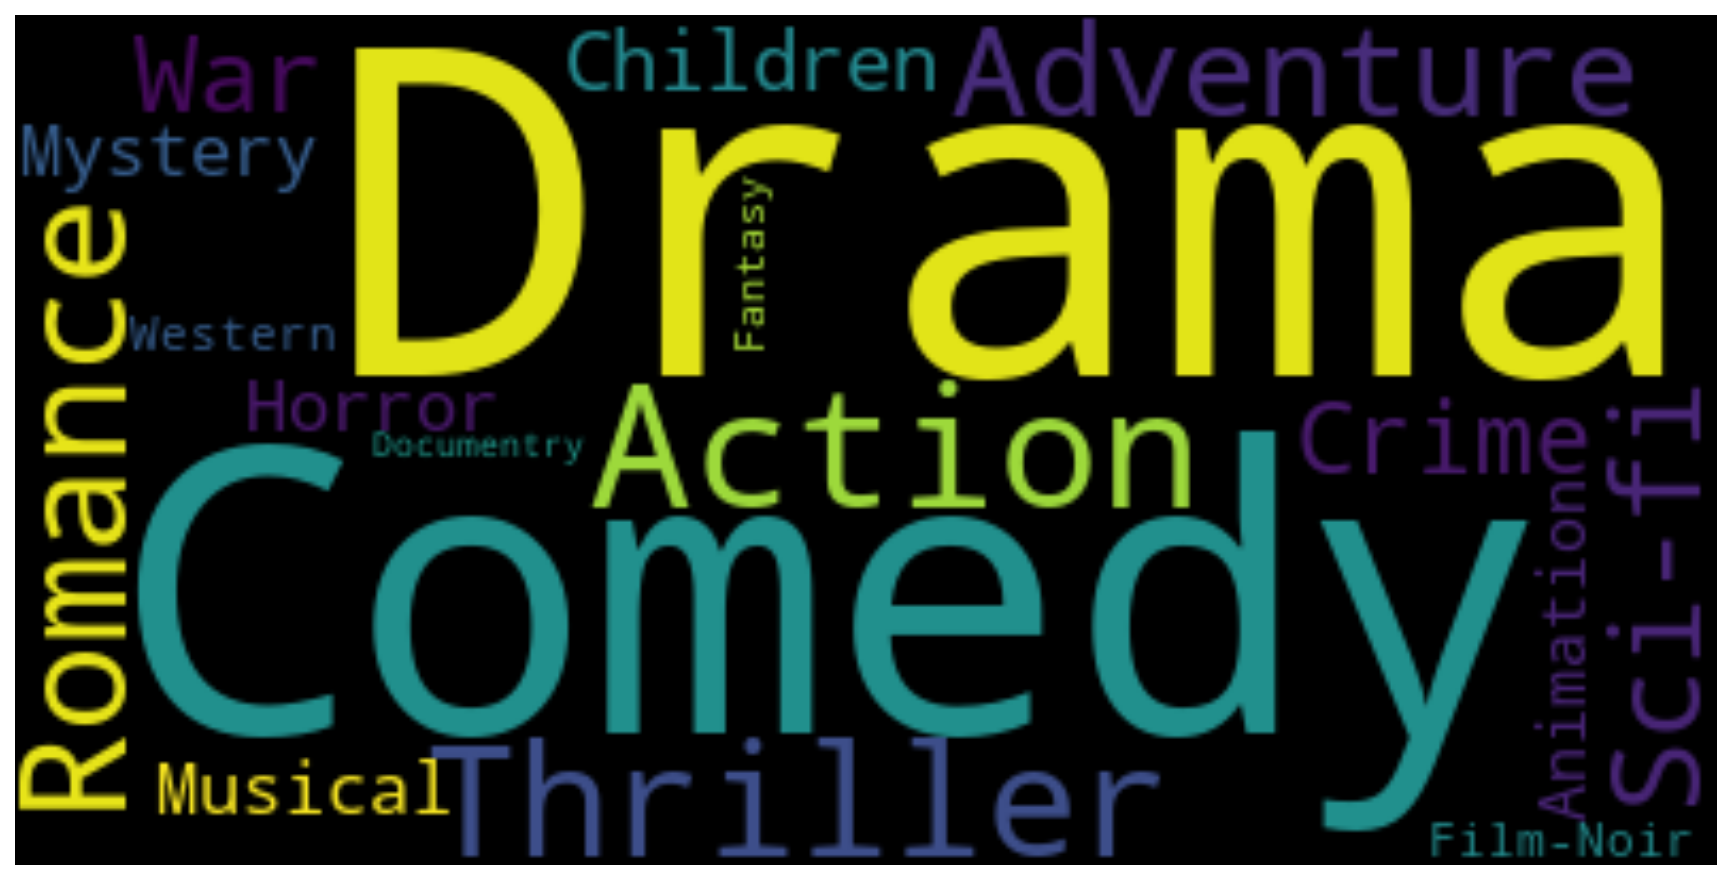

In [76]:
      
Genres=['Action','Adventure','Animation','Children','Comedy','Crime','Documentry','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-fi','Thriller','War','Western']
genres={}
for word in Genres :
    if word in df_combined.columns:
        genres[word]=df_combined[word].sum()
print(genres)    
from wordcloud import WordCloud
wordcloud=WordCloud(width=400,height=200,background_color='black',min_font_size=7).generate_from_frequencies(genres)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [77]:
df_n_ratings=pd.DataFrame(df_combined.groupby('movie-title')['rating'].mean())
df_n_ratings['total_ratings']=pd.DataFrame(df_combined.groupby('movie-title')['rating'].count())
df_n_ratings.rename(columns={'rating':'mean ratings'},inplace=True)
df_n_ratings.sort_values('total_ratings',ascending=False).head(10)

,mean ratings,total_ratings
movie-title,,
Star Wars (1977),4.358491,583
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


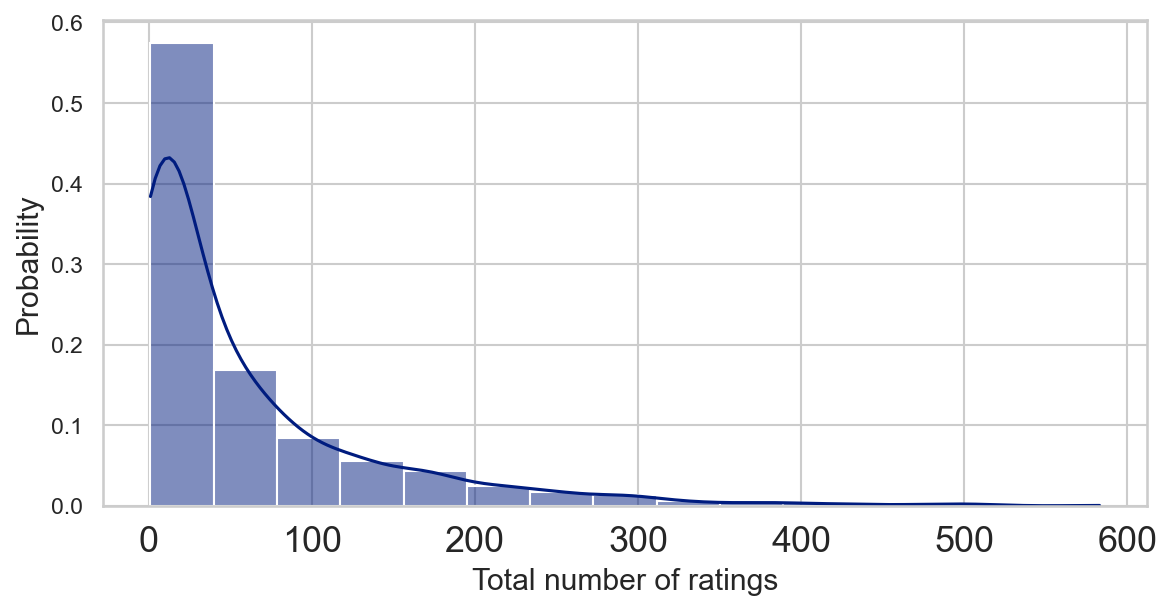

In [78]:
plt.figure(figsize=(8,4))
sns.histplot(df_n_ratings['total_ratings'],bins=15,kde=True,stat='probability')
plt.xlabel('Total number of ratings')
plt.ylabel('Probability')
plt.show()

In [79]:
df_n_ratings.sort_values('mean ratings',ascending=False).head(10)

,mean ratings,total_ratings
movie-title,,
They Made Me a Criminal (1939),5.0,1
Marlene Dietrich: Shadow and Light (1996),5.0,1
"Saint of Fort Washington, The (1993)",5.0,2
Someone Else's America (1995),5.0,1
Star Kid (1997),5.0,3
"Great Day in Harlem, A (1994)",5.0,1
Aiqing wansui (1994),5.0,1
Santa with Muscles (1996),5.0,2
Prefontaine (1997),5.0,3


In [80]:
print('Total no of users that gave rating of 5.0 : ',len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')
print('Total no of Individual users that gave rating of 5.0 : ', len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5) 
                                                                           & (df_n_ratings['total_ratings'] == 1)]))

Total no of users that gave rating of 5.0 :  10 

Total no of Individual users that gave rating of 5.0 :  6


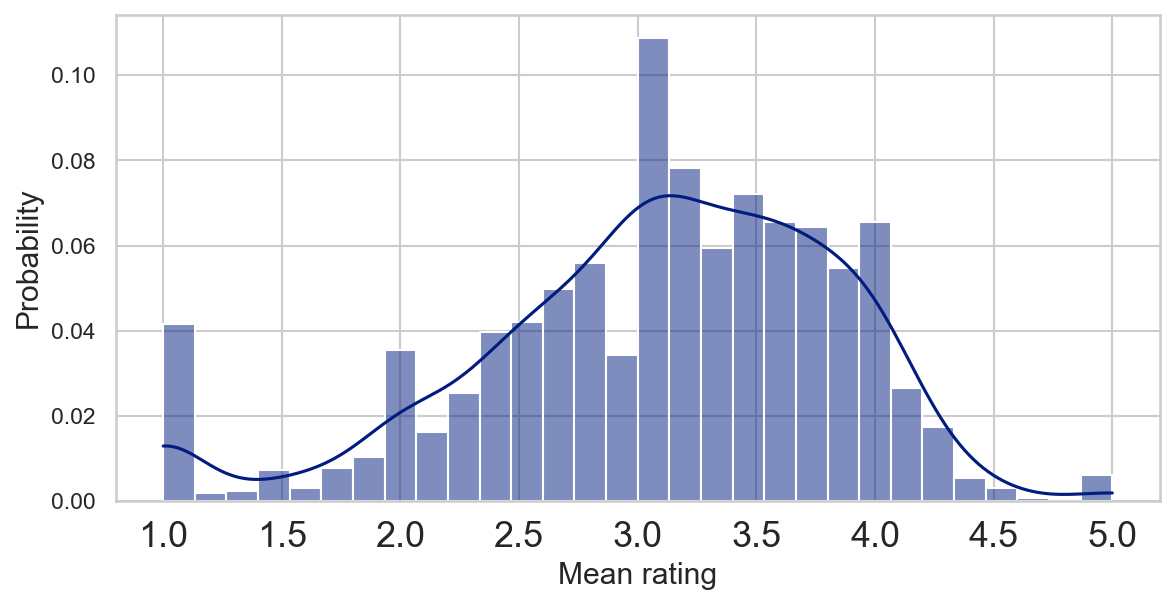

In [81]:
plt.figure(figsize=(8,4))
sns.histplot(df_n_ratings['mean ratings'],bins=30,kde=True,stat='probability')
plt.xlabel('Mean rating')
plt.ylabel('Probability')
plt.show()

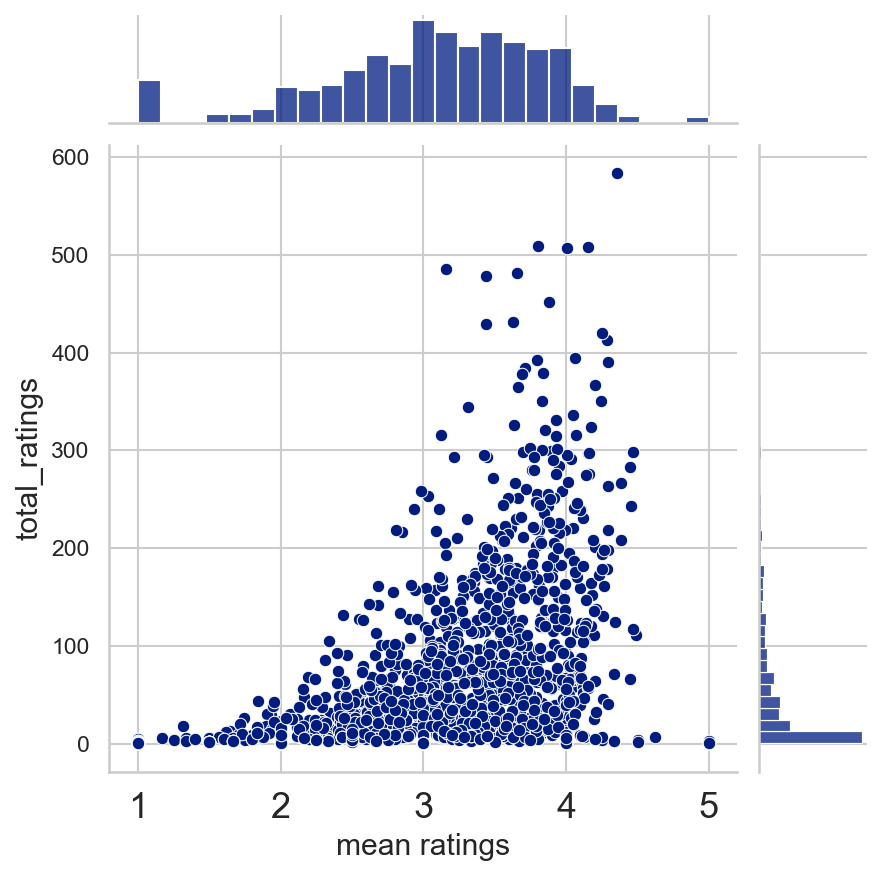

In [82]:
sns.jointplot(x = 'mean ratings', y = 'total_ratings', data = df_n_ratings )

In [83]:
util_mat = df_combined.pivot_table(index = 'userid', columns = 'movie-title', values = 'rating')
util_mat.head(20)

movie-title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
userid,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN
6,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,4.0,NaN,NaN,5.0,5.0,NaN,4.0,...,NaN,NaN,NaN,5.0,3.0,NaN,3.0,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
user_util_matrix=util_mat.copy()
# We will fill the row wise Nan's with the corresponding user's mean ratings 
# Here we assume avg ratings for the movie that is not rated.
user_util_matrix=user_util_matrix.apply(lambda row: row.fillna(row.mean()))
user_util_matrix.head(5)

movie-title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
userid,,,,,,,,,,,,,,,,,,,,,
1,2.333333,2.6,2.000000,5.000,3.02439,3.225806,3.0,4.000000,1.0,4.050847,...,1.0,3.285714,3.0,5.000,3.000000,2.772727,3.341463,2.166667,4.000000,3.0
2,2.333333,2.6,2.908257,4.344,3.02439,3.225806,3.5,3.969112,1.0,4.050847,...,1.0,3.285714,3.0,3.945,3.207921,2.772727,3.341463,2.166667,3.444444,3.0
3,2.333333,2.6,2.908257,4.344,2.00000,3.225806,3.5,3.969112,1.0,4.050847,...,1.0,3.285714,3.0,3.945,3.207921,2.772727,3.341463,2.166667,3.444444,3.0
4,2.333333,2.6,2.908257,4.344,3.02439,3.225806,3.5,3.969112,1.0,4.050847,...,1.0,3.285714,3.0,3.945,3.207921,2.772727,3.341463,2.166667,3.444444,3.0
5,2.333333,2.6,2.000000,4.344,3.02439,3.225806,3.5,4.000000,1.0,4.050847,...,1.0,3.285714,3.0,4.000,3.207921,2.772727,3.341463,2.166667,4.000000,3.0


In [85]:
user_util_matrix.T.corr()

userid,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
userid,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.884470,0.867513,0.881892,0.816587,0.839004,0.771996,0.891915,0.891105,0.867685,...,0.838247,0.874124,0.858235,0.875178,0.849634,0.868235,0.859768,0.896261,0.865621,0.805188
2,0.884470,1.000000,0.943446,0.959163,0.877166,0.907838,0.843628,0.957989,0.966721,0.950804,...,0.917891,0.960331,0.922877,0.962777,0.920300,0.947484,0.931960,0.971042,0.956681,0.892507
3,0.867513,0.943446,1.000000,0.936413,0.858801,0.895816,0.826486,0.939204,0.949890,0.932558,...,0.899633,0.941503,0.904569,0.945699,0.900496,0.926156,0.915843,0.953585,0.934992,0.875318
4,0.881892,0.959163,0.936413,1.000000,0.878437,0.902762,0.832139,0.961457,0.970981,0.948653,...,0.919183,0.961082,0.923541,0.952853,0.925644,0.945991,0.942380,0.977012,0.958865,0.892034
5,0.816587,0.877166,0.858801,0.878437,1.000000,0.829402,0.752456,0.875561,0.879367,0.861136,...,0.841533,0.873405,0.842850,0.872769,0.841275,0.863420,0.851470,0.889848,0.868508,0.827768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.868235,0.947484,0.926156,0.945991,0.863420,0.881907,0.825228,0.945580,0.954082,0.933469,...,0.903942,0.954765,0.909466,0.936366,0.912055,1.000000,0.923002,0.958132,0.940389,0.878631
940,0.859768,0.931960,0.915843,0.942380,0.851470,0.878238,0.810014,0.930995,0.943683,0.920816,...,0.888677,0.938869,0.892539,0.928656,0.894033,0.923002,1.000000,0.949806,0.931731,0.871525
941,0.896261,0.971042,0.953585,0.977012,0.889848,0.916462,0.849608,0.968750,0.983469,0.961691,...,0.927544,0.972144,0.935542,0.970395,0.931219,0.958132,0.949806,1.000000,0.968671,0.902953


In [86]:
user_util_matrix.corr()

movie-title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
movie-title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),1.000000e+00,4.946961e-16,-0.044083,-0.000471,0.014732,0.071235,3.171392e-16,-0.014519,NaN,9.154623e-04,...,NaN,7.424586e-16,NaN,-0.002543,9.526792e-02,5.184595e-02,-9.992493e-02,7.933705e-16,-3.276488e-02,NaN
1-900 (1994),4.946961e-16,1.000000e+00,-0.004327,0.088477,0.144024,0.127911,1.283588e-01,-0.059875,NaN,3.474620e-16,...,NaN,2.604662e-01,NaN,-0.087678,-4.711839e-02,-1.812997e-02,1.578587e-01,-1.999500e-01,-1.008262e-01,NaN
101 Dalmatians (1996),-4.408326e-02,-4.327142e-03,1.000000,-0.012807,0.021771,0.034097,9.947055e-02,-0.001652,NaN,5.477872e-03,...,NaN,1.850537e-02,NaN,0.041599,3.465869e-02,1.190322e-01,1.346053e-02,7.823140e-02,-2.822248e-02,NaN
12 Angry Men (1957),-4.706404e-04,8.847708e-02,-0.012807,1.000000,0.011465,0.020511,1.116704e-01,0.076067,NaN,1.487349e-01,...,NaN,1.192372e-02,NaN,0.031702,2.837992e-02,-3.856165e-02,1.647284e-02,9.226235e-02,2.019311e-02,NaN
187 (1997),1.473155e-02,1.440241e-01,0.021771,0.011465,1.000000,0.135381,8.004433e-04,-0.024846,NaN,2.220535e-02,...,NaN,2.351121e-01,NaN,0.032167,2.284157e-02,2.369701e-02,9.966069e-02,-1.034915e-01,4.572734e-02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Young Guns II (1990),5.184595e-02,-1.812997e-02,0.119032,-0.038562,0.023697,0.035220,-5.463934e-02,-0.013530,NaN,-1.448809e-02,...,NaN,2.959903e-16,NaN,0.093805,4.830229e-01,1.000000e+00,4.756914e-03,1.546413e-15,-3.057707e-02,NaN
"Young Poisoner's Handbook, The (1995)",-9.992493e-02,1.578587e-01,0.013461,0.016473,0.099661,0.055004,9.633285e-02,-0.029150,NaN,9.942529e-02,...,NaN,2.308808e-01,NaN,-0.061158,8.489017e-03,4.756914e-03,1.000000e+00,-1.134326e-01,-6.671105e-16,NaN
Zeus and Roxanne (1997),7.933705e-16,-1.999500e-01,0.078231,0.092262,-0.103491,-0.101238,4.304291e-02,0.003462,NaN,4.122210e-03,...,NaN,-1.871633e-01,NaN,0.016865,-4.741373e-17,1.546413e-15,-1.134326e-01,1.000000e+00,1.898287e-15,NaN


In [87]:
user_corr_mat=user_util_matrix.T.corr()
corr_user_1=user_corr_mat.iloc[0]
#for convinience, we will be condsidering only the correlation of all users with the first user only.
corr_user_1.sort_values(ascending=False,inplace=True)
corr_user_1


userid
1      1.000000
895    0.899655
376    0.899447
549    0.899061
105    0.898790
         ...   
774    0.685150
655    0.679936
279    0.673399
181    0.626109
405    0.447408
Name: 1, Length: 943, dtype: float64

In [88]:
corr_user_1.dropna(inplace = True)

In [89]:
# Neglecting the first corr values since it's of the user itself
top50_corr_users=corr_user_1[1:51]
top50_corr_users.iloc[0]
top50_corr_users

userid
895    0.899655
376    0.899447
549    0.899061
105    0.898790
926    0.898645
800    0.898172
876    0.897957
266    0.897929
273    0.897638
247    0.897572
687    0.897504
359    0.897386
594    0.897351
769    0.897265
631    0.897024
558    0.896816
319    0.896679
120    0.896471
728    0.896439
827    0.896322
794    0.896291
941    0.896261
662    0.896255
400    0.896231
700    0.896191
191    0.896123
171    0.896001
516    0.895987
754    0.895958
874    0.895921
27     0.895851
165    0.895750
785    0.895538
740    0.895469
540    0.895463
583    0.895449
111    0.895447
252    0.895421
680    0.895363
140    0.895358
920    0.895338
306    0.895245
799    0.895208
822    0.895186
564    0.895128
888    0.895124
441    0.895114
767    0.894917
691    0.894790
369    0.894740
Name: 1, dtype: float64

In [90]:
df_combined[df_combined['userid']==1]

,userid,productid,rating,movie-title,release-date,video-release-date,IMDb-URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-fi,Thriller,War,Western
202,1,61,4,Three Colors: White (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Trzy%20kolory...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
305,1,189,3,"Grand Day Out, A (1992)",01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Grand%20Day%2...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
333,1,33,4,Desperado (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Desperado%20(...,0,1,0,...,0,0,0,0,0,1,0,1,0,0
334,1,160,4,Glengarry Glen Ross (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Glengarry%20G...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
478,1,20,4,Angels and Insects (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Angels%20and%...,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92049,1,28,4,Apollo 13 (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Apollo%2013%2...,0,1,0,...,0,0,0,0,0,0,0,1,0,0
92487,1,172,5,"Empire Strikes Back, The (1980)",01-Jan-1980,NaN,http://us.imdb.com/M/title-exact?Empire%20Stri...,0,1,1,...,0,0,0,0,0,1,1,0,1,0
94019,1,122,3,"Cable Guy, The (1996)",14-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Cable%20Guy,%...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
96699,1,152,5,Sleeper (1973),01-Jan-1973,NaN,http://us.imdb.com/M/title-exact?Sleeper%20(1973),0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [91]:
df_combined[(df_combined['userid']==1)&(df_combined['productid']==300)]
# We would see that user 1 has not rated the movie id 600

,userid,productid,rating,movie-title,release-date,video-release-date,IMDb-URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-fi,Thriller,War,Western


In [92]:
print('300th Movie : ', movies['movie-title'][ movies['productid'] == 300 ].values)

300th Movie :  ['Air Force One (1997)']


So, let's calculate what ratings user 1 would give to the movie with the help of similarrity vector. And based on that rating, we can compare it with a threshold rating. If the rating is higher it will be visible to the active user in his/her recommended list.

In [93]:
df_n_ratings.loc["Air Force One (1997)"]

mean ratings       3.63109
total_ratings    431.00000
Name: Air Force One (1997), dtype: float64

In [94]:
top50_users = top50_corr_users.keys()

count = 0
users = list()
for user in top50_users:
    if df_combined[ (df_combined['userid'] == user) & (df_combined['productid'] == 300) ]['rating'].sum()  :
        count +=1
        users.append(user)

print(count)
users

15


[926, 800, 247, 687, 827, 941, 400, 191, 740, 540, 252, 920, 564, 441, 767]

There are 15 users similar to user 1 who have rated the movie, lets calculate what user 1 would rate the movie.

*Predicted Rating =sum of(weights*rating)/sum of[weights]

Here weights is the corresponding correlation of the user with the user1 



In [95]:
def predict_rating():
    sum_similarity=0.0
    sum_ratings=0.0
    for user in users:
        
        sum_ratings+=corr_user_1.iloc[user]*df_combined[(df_combined['userid']==user)&(df_combined['productid']==300)]['rating'].sum()
        
        sum_similarity+=corr_user_1.iloc[user]
    print(sum_ratings/sum_similarity)
predict_rating()        

3.5303546382102042


So, this is how a naive User-based CF works. Predicted ratings are calculated similarly for every user, (obviously for the movies he's not rated) and depending upon the threshold rating, the movie is either displayed on his recommended list or discarded.

In [96]:
# Let's find similar movies to jurassic Park
df_n_ratings.loc[['Jurassic Park (1993)']]

,mean ratings,total_ratings
movie-title,,
Jurassic Park (1993),3.720307,261


In [97]:
item_util_matrix = util_mat.copy()
item_util_matrix.head(10)

movie-title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
userid,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN
6,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,4.0,NaN,NaN,5.0,5.0,NaN,4.0,...,NaN,NaN,NaN,5.0,3.0,NaN,3.0,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
# We will fill the column wise NaN's with the corresponding movie's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the user that has not a rated movie.

item_util_matrix = item_util_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)
item_util_matrix.head(5)

movie-title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
userid,,,,,,,,,,,,,,,,,,,,,
1,2.333333,2.6,2.000000,5.000,3.02439,3.225806,3.0,4.000000,1.0,4.050847,...,1.0,3.285714,3.0,5.000,3.000000,2.772727,3.341463,2.166667,4.000000,3.0
2,2.333333,2.6,2.908257,4.344,3.02439,3.225806,3.5,3.969112,1.0,4.050847,...,1.0,3.285714,3.0,3.945,3.207921,2.772727,3.341463,2.166667,3.444444,3.0
3,2.333333,2.6,2.908257,4.344,2.00000,3.225806,3.5,3.969112,1.0,4.050847,...,1.0,3.285714,3.0,3.945,3.207921,2.772727,3.341463,2.166667,3.444444,3.0
4,2.333333,2.6,2.908257,4.344,3.02439,3.225806,3.5,3.969112,1.0,4.050847,...,1.0,3.285714,3.0,3.945,3.207921,2.772727,3.341463,2.166667,3.444444,3.0
5,2.333333,2.6,2.000000,4.344,3.02439,3.225806,3.5,4.000000,1.0,4.050847,...,1.0,3.285714,3.0,4.000,3.207921,2.772727,3.341463,2.166667,4.000000,3.0


In [99]:
item_util_matrix.isna().sum().sum()

0

In [100]:
item_util_matrix.corr()

movie-title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
movie-title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),1.000000e+00,4.946961e-16,-0.044083,-0.000471,0.014732,0.071235,3.171392e-16,-0.014519,NaN,9.154623e-04,...,NaN,7.424586e-16,NaN,-0.002543,9.526792e-02,5.184595e-02,-9.992493e-02,7.933705e-16,-3.276488e-02,NaN
1-900 (1994),4.946961e-16,1.000000e+00,-0.004327,0.088477,0.144024,0.127911,1.283588e-01,-0.059875,NaN,3.474620e-16,...,NaN,2.604662e-01,NaN,-0.087678,-4.711839e-02,-1.812997e-02,1.578587e-01,-1.999500e-01,-1.008262e-01,NaN
101 Dalmatians (1996),-4.408326e-02,-4.327142e-03,1.000000,-0.012807,0.021771,0.034097,9.947055e-02,-0.001652,NaN,5.477872e-03,...,NaN,1.850537e-02,NaN,0.041599,3.465869e-02,1.190322e-01,1.346053e-02,7.823140e-02,-2.822248e-02,NaN
12 Angry Men (1957),-4.706404e-04,8.847708e-02,-0.012807,1.000000,0.011465,0.020511,1.116704e-01,0.076067,NaN,1.487349e-01,...,NaN,1.192372e-02,NaN,0.031702,2.837992e-02,-3.856165e-02,1.647284e-02,9.226235e-02,2.019311e-02,NaN
187 (1997),1.473155e-02,1.440241e-01,0.021771,0.011465,1.000000,0.135381,8.004433e-04,-0.024846,NaN,2.220535e-02,...,NaN,2.351121e-01,NaN,0.032167,2.284157e-02,2.369701e-02,9.966069e-02,-1.034915e-01,4.572734e-02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Young Guns II (1990),5.184595e-02,-1.812997e-02,0.119032,-0.038562,0.023697,0.035220,-5.463934e-02,-0.013530,NaN,-1.448809e-02,...,NaN,2.959903e-16,NaN,0.093805,4.830229e-01,1.000000e+00,4.756914e-03,1.546413e-15,-3.057707e-02,NaN
"Young Poisoner's Handbook, The (1995)",-9.992493e-02,1.578587e-01,0.013461,0.016473,0.099661,0.055004,9.633285e-02,-0.029150,NaN,9.942529e-02,...,NaN,2.308808e-01,NaN,-0.061158,8.489017e-03,4.756914e-03,1.000000e+00,-1.134326e-01,-6.671105e-16,NaN
Zeus and Roxanne (1997),7.933705e-16,-1.999500e-01,0.078231,0.092262,-0.103491,-0.101238,4.304291e-02,0.003462,NaN,4.122210e-03,...,NaN,-1.871633e-01,NaN,0.016865,-4.741373e-17,1.546413e-15,-1.134326e-01,1.000000e+00,1.898287e-15,NaN


In [101]:
item_corr_matrix = item_util_matrix.corr()

In [102]:
jurassic_park_corr=item_corr_matrix['Jurassic Park (1993)']
jurassic_park_corr = jurassic_park_corr.sort_values(ascending=False)
jurassic_park_corr.dropna(inplace=True)

In [103]:
movies_similar_to_jurassic_park = pd.DataFrame(data=jurassic_park_corr.values, columns=['Correlation'], 
                                               index = jurassic_park_corr.index)
movies_similar_to_jurassic_park = movies_similar_to_jurassic_park.join(df_n_ratings['total_ratings'])
movies_similar_to_jurassic_park.head(10)

,Correlation,total_ratings
movie-title,,
Jurassic Park (1993),1.000000,261
Speed (1994),0.320391,230
Back to the Future (1985),0.302630,350
"Fugitive, The (1993)",0.298525,336
Indiana Jones and the Last Crusade (1989),0.294236,331
Terminator 2: Judgment Day (1991),0.291161,295
Raiders of the Lost Ark (1981),0.264174,420
Pretty Woman (1990),0.248851,164
Aliens (1986),0.245207,284


In [104]:
movies_similar_to_jurassic_park = movies_similar_to_jurassic_park[1:]
movies_similar_to_jurassic_park[ movies_similar_to_jurassic_park['total_ratings'] > 100 ].sort_values(ascending=False,
                                                                                          by=['Correlation']).head(10)

,Correlation,total_ratings
movie-title,,
Speed (1994),0.320391,230
Back to the Future (1985),0.302630,350
"Fugitive, The (1993)",0.298525,336
Indiana Jones and the Last Crusade (1989),0.294236,331
Terminator 2: Judgment Day (1991),0.291161,295
Raiders of the Lost Ark (1981),0.264174,420
Pretty Woman (1990),0.248851,164
Aliens (1986),0.245207,284
Mission: Impossible (1996),0.240320,344


# Model based Collaborative Filtering
Here we will be using dimensionality reduction methods to improve robusteness and accuracy of Memory-Based CF. Basically, we compress user-item matrix into a low dimension matrix. We use techniues like SVD which is a low-rank factorization method, PCA which is used for dimensionality reduction etc.

Model-based methods are based on matric factorization and are better at dealing with sparsity.

* We will be using a 'Surprise' library to implement SVD,KNN and NMF.
* Surprise Library has almost all the algorithms implemented that are required for model-based Recommendation systems.


In [105]:
from surprise import Reader, Dataset, KNNBasic, SVD, NMF
from surprise.model_selection import GridSearchCV, cross_validate


In [106]:
reader = Reader(rating_scale=(0.0, 5.0))

data = Dataset.load_from_df( ratings[['userid', 'productid', 'rating']], reader = reader )

# K-Nearest Neighbours

In [107]:
# Split data into k-folds
# data.split(n_folds=5)

In [108]:
# Compute Mean Squared Distance Similarity
sim_options = {'name' : 'msd'}

algo = KNNBasic(k=20, sim_options=sim_options )
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9771  0.9721  0.9727  0.9706  0.9907  0.9766  0.0074  
Fit time          0.27    0.27    0.28    0.27    0.28    0.28    0.01    
Test time         1.70    1.63    1.60    1.63    1.62    1.64    0.03    


{'test_rmse': array([0.97711538, 0.97211709, 0.97270218, 0.97055191, 0.99073973]),
 'fit_time': (0.26826000213623047,
  0.2703268527984619,
  0.2847287654876709,
  0.270946741104126,
  0.2844583988189697),
 'test_time': (1.6989898681640625,
  1.6326665878295898,
  1.5965962409973145,
  1.6264400482177734,
  1.6215214729309082)}

#### Tuning using GridSearchCV 

In [109]:
n_neighbours = [10,20,30]
param_grid = {'n_neighbours' : n_neighbours}

gs = GridSearchCV(KNNBasic, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [110]:
algo = SVD()
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9374  0.9313  0.9377  0.9352  0.9397  0.9363  0.0029  
Fit time          0.65    0.68    0.66    0.70    0.73    0.69    0.03    
Test time         0.08    0.08    0.08    0.08    0.08    0.08    0.00    


{'test_rmse': array([0.93742718, 0.93127707, 0.9377138 , 0.93518084, 0.93967377]),
 'fit_time': (0.6540474891662598,
  0.6831071376800537,
  0.6640169620513916,
  0.7042412757873535,
  0.7280783653259277),
 'test_time': (0.0790715217590332,
  0.08375930786132812,
  0.07700228691101074,
  0.08018183708190918,
  0.07965660095214844)}

In [111]:
param_grid = {'n_factors' : [50, 75], 'lr_all' : [0.5, 0.05], 'reg_all' : [0.06, 0.04]}

gs = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')


###############
Best Score : 0.9398278244294855
Best Parameters : {'n_factors': 75, 'lr_all': 0.05, 'reg_all': 0.06}
###############


In [ ]:
# Further code uses nerual networks in order to  make further recommendations and honestly I haven't learned neural netwroks in detail so this will be continued after I have learned and now I am going to pursue handwritten integer recognition  